In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learning:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
df = pd.read_csv('datasets/household_energy_consumption/household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
print(droping_list_all)

[0, 1, 2, 3, 4, 5, 6]


In [7]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [8]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [10]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [18]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917


In [19]:
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


In [12]:
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [14]:
# fit network
history = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)


Epoch 1/20
126/126 - 2s - loss: 0.0210 - val_loss: 0.0120 - 2s/epoch - 18ms/step
Epoch 2/20
126/126 - 1s - loss: 0.0122 - val_loss: 0.0108 - 554ms/epoch - 4ms/step
Epoch 3/20
126/126 - 1s - loss: 0.0117 - val_loss: 0.0102 - 558ms/epoch - 4ms/step
Epoch 4/20
126/126 - 1s - loss: 0.0113 - val_loss: 0.0099 - 667ms/epoch - 5ms/step
Epoch 5/20
126/126 - 1s - loss: 0.0112 - val_loss: 0.0098 - 908ms/epoch - 7ms/step
Epoch 6/20
126/126 - 1s - loss: 0.0111 - val_loss: 0.0096 - 598ms/epoch - 5ms/step
Epoch 7/20
126/126 - 1s - loss: 0.0110 - val_loss: 0.0095 - 616ms/epoch - 5ms/step
Epoch 8/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0095 - 550ms/epoch - 4ms/step
Epoch 9/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0095 - 579ms/epoch - 5ms/step
Epoch 10/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0096 - 579ms/epoch - 5ms/step
Epoch 11/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0096 - 603ms/epoch - 5ms/step
Epoch 12/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0097 - 666ms/epoch - 5ms/step
Epo

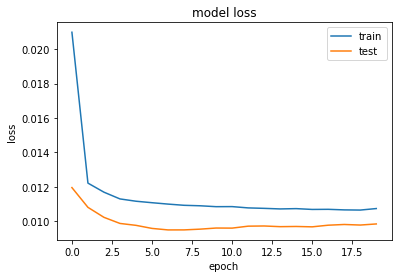

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 7))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

808/808 [==============================] - 1s 1ms/step
Test RMSE: 0.639


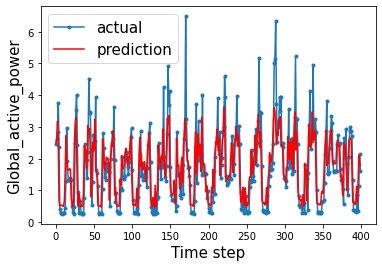

In [17]:
aa=[x for x in range(400)]
plt.plot(aa, inv_y[:400], marker='.', label="actual")
plt.plot(aa, inv_yhat[:400], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()